In [14]:
import os
import numpy as np
import uproot
import yaml
import re

# plot_asym helper code

In [241]:
def print_yaml_structure(data, indent=0):
    for key, value in data.items():
        print(" " * indent + key + ":")
        if isinstance(value, dict):
            print_yaml_structure(value, indent+2)
        else:
            if(type(value)==list):
                value="<LIST>"
            print(" " * (indent+2) + str(value))

In [141]:
def extract_numbers(string):
    pattern = r"\d+(?:\.\d+)?"
    numbers = re.findall(pattern, string)
    return [float(number) for number in numbers]

In [228]:
def read_splot(subdir):
    relpath = subdir.split('/')[-1]
    
    x_values = extract_numbers(relpath)
    param_names = []
    param_values = []
    param_errors = []
    # Open the TTree called ResultTree
    result_file = os.path.join(subdir, 'ResultsHSMinuit2.root')
    with uproot.open(result_file) as f:
        if 'ResultTree' in f:
            tree = f['ResultTree']

            # Loop over all branches in the tree
            for branch_name in tree.keys():

                # Skip the error branches
                if branch_name.endswith('_err'):
                    continue
                if(branch_name in ["NLL"]):
                    continue
                # Get the parameter name and its value
                param_name = branch_name
                param_value = tree[param_name].array()[0]

                # Get the corresponding error branch
                err_branch_name = f'{param_name}_err'
                if err_branch_name not in tree:
                    continue

                # Get the parameter error
                param_error = tree[err_branch_name].array()[0]

                # Append the data to the arrays
                if param_name not in param_names:
                    param_names.append(param_name)
                    param_values.append([float(param_value)])
                    param_errors.append([float(param_error)])
                else:
                    index = param_names.index(param_name)
                    param_values[index].append(float(param_value))
                    param_errors[index].append(float(param_error))
    return x_values, param_names, param_values, param_errors

In [2]:
def create_asym_yaml(project_name=""):
    path=f"/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/{project_name}/asym"
    data = {}
    nested_dict = {}
    current_dict = nested_dict
    for root, dirs, files in os.walk(path):
        for dir in dirs:
            subdir = os.path.join(root,dir)
            split_subdir = subdir.split("/")
            asym_index = split_subdir.index("asym")
            result = split_subdir[asym_index+1:]
            if any(element.startswith("out") for element in result) and \
               result.index(next(filter(lambda x: x.startswith("out"), result))) < len(result) - 1 and \
                ".ipynb_checkpoints" not in result:
                
                string = ""
                # Now get sPlot or Sdbnd data
                if("outObsBins_splot" in result):
                    x_values, param_names, param_values, param_errors = read_splot(subdir)
                    result[-2]="splot"
                elif("outSdbndBins" in result):
                    result[-2]="sideband"
                    continue
                else:
                    x_values, param_names, param_values, param_errors = read_splot(subdir)
                    result[-2]="standard"
                data_list=result

                
                for i, key in enumerate(data_list[:-1]):
                    if(not key in current_dict):  
                        current_dict[key] = {}
                    if(i==len(data_list[:-1])-1): break
                    current_dict = current_dict[key]

                
                if 'x' in current_dict[key]:
                    current_dict[key]["x"].extend(x_values)
                    for p, v, e in zip(param_names, param_values, param_errors):
                        if p in current_dict[key]:
                            current_dict[key][p]["value"].extend(v)
                            current_dict[key][p]["error"].extend(e)
                        else:
                            current_dict[key][p] = {"value": v, "error": e}
                else:
                    current_dict[key] = {"x": x_values}
                    for p, v, e in zip(param_names, param_values, param_errors):
                        current_dict[key][p] = {"value": v, "error": e}
                current_dict = nested_dict
                
                # Write updated nested dictionary to the YAML file
                with open("out.yaml", "w") as file:
                    yaml.dump(nested_dict, file)
                    
    with open("out.yaml", "w") as file:
        yaml.dump(nested_dict, file)

In [247]:
def get_data_from_yaml(data, headers, par):

    current_dict = data
    for header in headers:
        current_dict = current_dict[header]
    
    
    x = current_dict["x"]
    y = current_dict[par]["value"]
    yerr = current_dict[par]["error"]

    return x, y, yerr

# Bin Migration helper code

In [2]:
import yaml
import uproot
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import csv
from itertools import product
import ROOT
import shutil

Welcome to JupyROOT 6.22/06


In [3]:
def save_confusion_matrix(confusion_matrix, file_name):
    with open(file_name, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in confusion_matrix:
            csv_writer.writerow(row)

In [7]:
def bin_migration(project_dir, channel, version, binstruct, cut_name):
    file_path = f"{project_dir}/volatile/data/{channel}/{version}_merged.root"
    
    dimension_names = binstruct["dimensionNames"]
    bin_edges = binstruct["binEdges"]
    
    dimension_names_underscore = '_'.join(dimension_names)
    
    out_dir = f"{project_dir}/systematics/bin_migration/{channel}"
    # Check if the directory exists
    if not os.path.exists(out_dir):
        # If it does not exist, create it using os.makedirs
        os.makedirs(out_dir)
    
    cut_library_file = "/work/clas12/users/gmat/clas12/clas12_dihadrons/utils/cut_library.yaml"
    
    shutil.copy(cut_library_file, out_dir)
    
    with open(cut_library_file) as f:
        cuts = yaml.safe_load(f)

    cut_dict = cuts.get(cut_name, {})  # get the dictionary of cuts for the given cut_name
    cut_var = []
    cut_min = []
    cut_max = []
    cut_strings = []
    for var, cut_range in cut_dict.items():
        cut_var.append(var)
        cut_min.append(float(cut_range.split(" ")[0]))
        cut_max.append(float(cut_range.split(" ")[1]))
        cut_strings.append(f"{cut_min[-1]} < {cut_var[-1]} < {cut_max[-1]}")
    if(channel=="pi0_pi0"):
        cut_var.append("p_11")
        cut_var.append("p_12")
        cut_var.append("p_21")
        cut_var.append("p_22")
        cut_min.append(0.9)
        cut_min.append(0.9)
        cut_min.append(0.9)
        cut_min.append(0.9)
        cut_max.append(1.0)
        cut_max.append(1.0)
        cut_max.append(1.0)
        cut_max.append(1.0)
        cut_strings.append("p(gamma1)>0.9")
        cut_strings.append("p(gamma2)>0.9")
        cut_strings.append("p(gamma3)>0.9")
        cut_strings.append("p(gamma4)>0.9")
    elif(channel=="piplus_pi0" or channel=="piminus_pi0"):
        cut_var.append("p_21")
        cut_var.append("p_22")
        cut_min.append(0.9)
        cut_min.append(0.9)
        cut_max.append(1.0)
        cut_max.append(1.0)
        cut_strings.append("p(gamma1)>0.9")
        cut_strings.append("p(gamma2)>0.9")
        
    with uproot.open(file_path) as file:
        ttree = file["dihadron"]
        
        # apply the cuts to select events
        all_cuts = np.array(ttree["MCmatch"].array()==1)
        for v,vmin,vmax in zip(cut_var,cut_min,cut_max):
            varr = np.array(ttree[v].array())
            all_cuts*= (varr>vmin) * (varr<vmax)

        reco_branches = [ttree[dimension_name].array()[all_cuts] for dimension_name in dimension_names]
        true_branches = [ttree[f"true{dimension_name}"].array()[all_cuts] for dimension_name in dimension_names]
    
    n_dimensions = len(dimension_names)
    digitize = lambda values, edges: np.digitize(values, edges) - 1
    reco_bins = [digitize(reco, edges) for reco, edges in zip(reco_branches, bin_edges)]
    true_bins = [digitize(true_, edges) for true_, edges in zip(true_branches, bin_edges)]

    all_bins = list(product(*[range(len(edges) - 1) for edges in bin_edges]))
    bin_labels = [tuple(map(str, bins)) for bins in all_bins]

    confusion_matrix = np.zeros((len(all_bins), len(all_bins)))
    for reco, true_ in zip(zip(*reco_bins), zip(*true_bins)):
        if all(0 <= reco_bin < len(edges) - 1 for reco_bin, edges in zip(reco, bin_edges)) and all(0 <= true_bin < len(edges) - 1 for true_bin, edges in zip(true_, bin_edges)):
            reco_idx = all_bins.index(reco)
            true_idx = all_bins.index(true_)
            confusion_matrix[reco_idx, true_idx] += 1
    
    # Set bins with 0 sum to 0
    col_sums = confusion_matrix.sum(axis=0)
    col_sums[col_sums==0]=1

    # Normalize the confusion matrix
    cm = confusion_matrix / col_sums
    #cm = confusion_matrix / confusion_matrix.sum(axis=0, keepdims=True)
    cm = np.flipud(cm)
    
    # Calculate the size of the figure based on the number of bins in each dimension
    fig_size = (cm.shape[0], 0.75*cm.shape[0])

    norm = mcolors.LogNorm(vmin=cm.min()+1e-6, vmax=cm.max())
    fig, ax = plt.subplots(figsize=fig_size)
    im = plt.imshow(cm, interpolation="nearest", cmap="Blues", aspect="auto", norm=norm)

    ax.set_xticks(np.arange(len(all_bins)))
    ax.set_yticks(np.arange(len(all_bins)))
    # Convert tuple of integers to list of integers as tick labels
    ax.set_xticklabels(list(map(lambda x: str(x).replace("(", "").replace(",)", "").replace(")","").replace("'", ""), bin_labels)), fontsize=12)
    ax.set_yticklabels(list(map(lambda x: str(x).replace("(", "").replace(",)", "").replace(")","").replace("'", ""), bin_labels[::-1])), fontsize=12)
    # Add x-axis and y-axis labels
    ax.set_xlabel("Monte Carlo Generated Bin", fontsize=14)
    ax.set_ylabel("Reconstructed Bin", fontsize=14)
    # Add title
    ax.set_title(f"Bin Migration for {dimension_names} bins",fontsize=22)
    
    for i in range(len(all_bins)):
        for j in range(len(all_bins)):
            ax.text(j, i, f"{cm[i, j]:.3f}",
                    ha="center", va="center", color="black" if cm[i, j] < 0.5 * cm.max() else "white", fontsize=12)

    bin_centers = [0.5 * (np.array(edges[:-1]) + np.array(edges[1:])) for edges in bin_edges]
    legend_elements = [f"{dim}: bin {i} = {center:.2f}" for dim, centers in zip(dimension_names, bin_centers) for i, center in enumerate(centers)]
    legend_text = "\n".join(legend_elements)
    legend_text = "Cuts:\n"+"\n".join(cut_strings)+"\n\n"+legend_text
    ax.annotate(legend_text, xy=(1.05, 0.5), xycoords="axes fraction", fontsize=15, ha="left", va="center")

    plt.tight_layout()
    plotname = f'{out_dir}/figure_{dimension_names_underscore}_{version}_{cut_name}.png'
    plt.savefig(plotname)
    # Save the confusion matrix
    csvname = f'{out_dir}/matrix_{dimension_names_underscore}_{version}_{cut_name}.csv'
    save_confusion_matrix(cm, csvname)
    print("Saved to",csvname)
    plt.close()

# Kinematics Helper Code

In [133]:

def kinematics(project_dir, channel, version, binstruct, branchname, cut_name):
    file_path = f"{project_dir}/volatile/data/{channel}/{version}_merged.root"
    dimension_names = binstruct["dimensionNames"]
    bin_edges = binstruct["binEdges"]
    
    # Open the ROOT file and TTree
    root_file = ROOT.TFile(file_path, "READ")
    tree = root_file.Get("dihadron")

    # Determine if the binning is 1D or 2D
    is_2d_binning = len(dimension_names) == 2

    # Create the grid of TPads
    n_columns = len(bin_edges[0]) - 1
    n_rows = len(bin_edges[1]) - 1 if is_2d_binning else 1
    pad_width = 1.0 / n_columns
    pad_height = 1.0 / n_rows

    # Define padding for major axes
    x_padding = 0.1
    y_padding = 0.1

    # Create the TCanvas with extra padding for the axes
    canvas = ROOT.TCanvas("canvas", "Kinematics", 100 + int(200 * (n_columns + x_padding)), 100 + int(200 * (n_rows + y_padding)))
    canvas.cd()

    pads = []
    for i in range(n_rows):
        pad_row = []
        for j in range(n_columns):
            pad_name = f"pad_{i}_{j}"
            pad = ROOT.TPad(pad_name, pad_name,
                           j * pad_width + x_padding,
                           (n_rows - i - 1) * pad_height + y_padding,
                           (j + 1) * pad_width + x_padding,
                           (n_rows - i) * pad_height + y_padding)
            pad.SetMargin(0, 0, 0, 0)
            if i == 0 and j == 0:
                pad.Draw()
            else:
                pad.Draw("same")
            pad_row.append(pad)
        pads.append(pad_row)

    hists = []
    # Draw histograms in TPads
    for i in range(n_rows):
        for j in range(n_columns):
            pads[i][j].cd()
            x_bin_range = f"{dimension_names[0]} > {bin_edges[0][j]} && {dimension_names[0]} < {bin_edges[0][j+1]}"
            y_bin_range = f"{dimension_names[1]} > {bin_edges[1][i]} && {dimension_names[1]} < {bin_edges[1][i+1]}" if is_2d_binning else ""
            cut = f"{x_bin_range}"
            hist = ROOT.TH1F(f"hist_{i}_{j}", "", 100, 0, 1)
            tree.Draw(f"{branchname}>>hist_{i}_{j}", cut, "goff")
            hists.append(hist)

    # Draw external axes
    canvas.cd()
    external_x_axis = ROOT.TGaxis(x_padding, y_padding - 0.05, 1, y_padding - 0.05, bin_edges[0][0], bin_edges[0][-1], 510, "")
    external_x_axis.SetTitle(dimension_names[0])
    external_x_axis.Draw("same")

    if is_2d_binning:
        external_y_axis = ROOT.TGaxis(x_padding - 0.05,y_padding, x_padding - 0.05, 1, bin_edges[1][0], bin_edges[1][-1], 510, "")
        external_y_axis.SetTitle(dimension_names[1])
        external_y_axis.Draw()



    canvas.Draw()
    canvas.SaveAs("output_canvas.png")

    # Cleanup
    root_file.Close()

In [86]:
def kinematics(project_dir, channel, version, binstruct, branchname, cut_name):
    file_path = f"{project_dir}/volatile/data/{channel}/{version}_merged.root"
    dimension_names = binstruct["dimensionNames"]
    bin_edges = binstruct["binEdges"]
    
    # Open the ROOT file and TTree
    root_file = ROOT.TFile(file_path, "READ")
    tree = root_file.Get("dihadron")

    # Determine if the binning is 1D or 2D
    is_2d_binning = len(dimension_names) == 2

    # Define padding for major axes
    x_padding = 0.05
    y_padding = 0.2
    # Create the grid of TPads
    n_columns = len(bin_edges[0]) - 1
    n_rows = len(bin_edges[1]) - 1 if is_2d_binning else 1
    pad_width = (1.0 - 2*x_padding) / n_columns 
    pad_height = (1.0 - 2*y_padding) / n_rows 
    
    pads = []

    # Create the TCanvas
    canvas = ROOT.TCanvas("canvas", "Kinematics", 100+200*n_columns, 100+200*n_rows)
    canvas.cd()

    for i in range(n_rows):
        pad_row = []
        for j in range(n_columns):
            pad_name = f"pad_{i}_{j}"
            pad = ROOT.TPad(pad_name, pad_name, j * pad_width+x_padding, (n_rows - i - 1) * pad_height+y_padding, (j + 1) * pad_width+x_padding, (n_rows - i) * pad_height+y_padding)
            pad.SetMargin(0, 0, 0, 0)
            if i == 0 and j == 0:
                pad.Draw()
            else:
                pad.Draw("same")
            pad_row.append(pad)
        pads.append(pad_row)

    hists = []
    max_height = 0
    # Draw histograms in TPads
    for i in range(n_rows):
        for j in range(n_columns):
            pads[i][j].cd()
            ROOT.gStyle.SetOptStat(0)
            x_bin_range = f"{dimension_names[0]} > {bin_edges[0][j]} && {dimension_names[0]} < {bin_edges[0][j+1]}"
            y_bin_range = f"{dimension_names[1]} > {bin_edges[1][i]} && {dimension_names[1]} < {bin_edges[1][i+1]}" if is_2d_binning else ""
            cut = f"{x_bin_range}"
            if(is_2d_binning):
                cut+=f"&&{y_bin_range}"
            
            hist = ROOT.TH1F(f"hist_{i}_{j}", "", 100, 0, 1)
            tree.Draw(f"{branchname}>>hist_{i}_{j}", cut, "goff")
            hist.Draw()
            if i == n_rows-1 and j == 0:
                axis_min = 0
                axis_max = hist.GetMaximum()
                axis_range = axis_max - axis_min
                external_y_axis_left_bottom = ROOT.TGaxis(x_padding/2, y_padding, x_padding/2, 1-y_padding, axis_min, axis_max, 510, "R+")
                external_y_axis_left_bottom.SetTitle("Counts")
                external_y_axis_left_bottom.SetTitleOffset(0.5)
                external_y_axis_left_bottom.SetTitleSize(0.1)
                external_y_axis_left_bottom.SetLabelSize(0.07)
                external_y_axis_left_bottom.SetLabelOffset(0.01)
                canvas.cd()
                external_y_axis_left_bottom.Draw()
            hists.append(hist)
            if hist.GetMaximum() > max_height:
                max_height = hist.GetMaximum()

    # Set the maximum y-axis range of all histograms to max_height
    for hist in hists:
        hist.SetMaximum(max_height)
        
    # Draw external axes
    canvas.cd()
    # X-axis
    x_axis_n_div = len(bin_edges[0]) - 1
    x_axis_labels = [f"{bin_edges[0][i]:.3f}" for i in range(x_axis_n_div + 1)]
    external_x_axis = ROOT.TGaxis(x_padding, y_padding/1.25, 1-x_padding, y_padding/1.25, 0, x_axis_n_div, 500+x_axis_n_div, "<")
    external_x_axis.SetTitle(dimension_names[0])
    external_x_axis.SetLabelSize(0.07)
    external_x_axis.SetTitleSize(0.1)
    external_x_axis.SetTitleOffset(0.67)
    for i in range(x_axis_n_div + 1):
        external_x_axis.ChangeLabel(i + 1, -1, -1, -1, -1, -1, x_axis_labels[i])
    external_x_axis.Draw("same")

    if is_2d_binning:
        y_axis_n_div = len(bin_edges[1]) - 1
        y_axis_labels = [f"{bin_edges[1][i]:.2f}" for i in range(y_axis_n_div + 1)]
        external_y_axis = ROOT.TGaxis(x_padding/2, y_padding, x_padding/2, 1-y_padding, bin_edges[1][0], bin_edges[1][-1], 500+y_axis_n_div, "S")
        external_y_axis.SetTitle(dimension_names[1])
        for i in range(y_axis_n_div + 1):
            external_y_axis.ChangeLabel(i + 1, -1, -1, -1, -1, -1, y_axis_labels[i])
        external_y_axis.Draw()

    canvas.Draw()
    canvas.SaveAs("output_canvas.png")

    # Cleanup
    root_file.Close()

Info in <TCanvas::Print>: png file output_canvas.png has been created


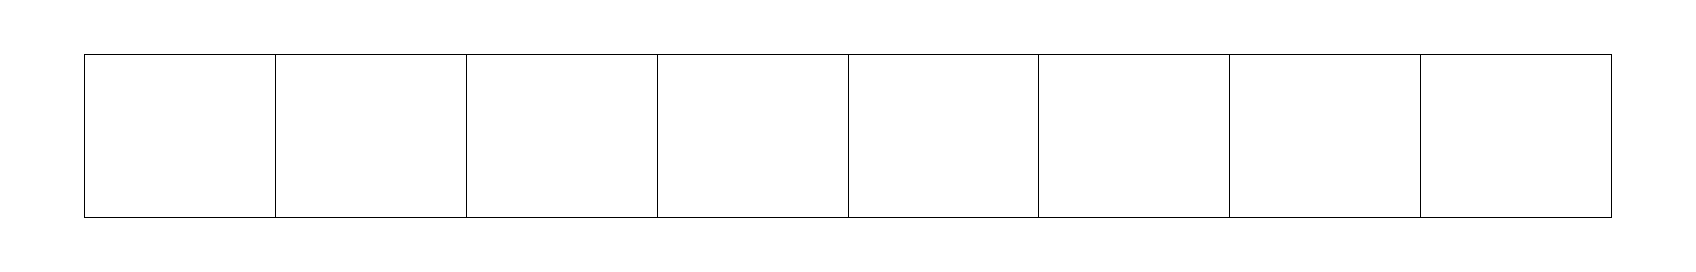

In [87]:
# Read the YAML file for the Binning
with open(f"binning_files/Binning.yaml", "r") as file:
    data = yaml.safe_load(file)
    
kinematics("/work/clas12/users/gmat/clas12/clas12_dihadrons/projects/ana_v1/","piplus_piminus","MC_RGA_inbending",data["binningStructures"][0],"z","")

In [1]:
import ROOT

Welcome to JupyROOT 6.22/06


In [4]:
f=ROOT.TFile("/volatile/clas12/users/gmat/clas12analysis.sidis.data/clas12_dihadrons/projects/ana_v1/data/piplus_pi0/MC_3051_0.root")

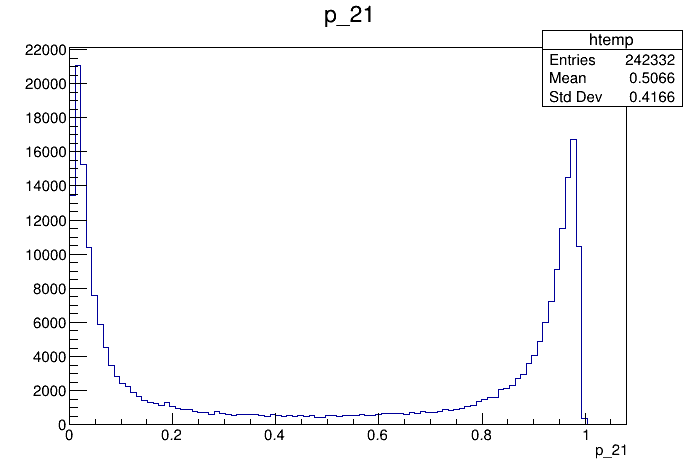

In [5]:
t=f.Get("dihadron")
c=ROOT.TCanvas()
t.Draw("p_21")
c.Draw()

Error in <TTreeFormula::Compile>:  Bad numerical expression : "gbt_0_calo"
Info in <TSelectorDraw::AbortProcess>: Variable compilation failed: {gbt_0_calo,}


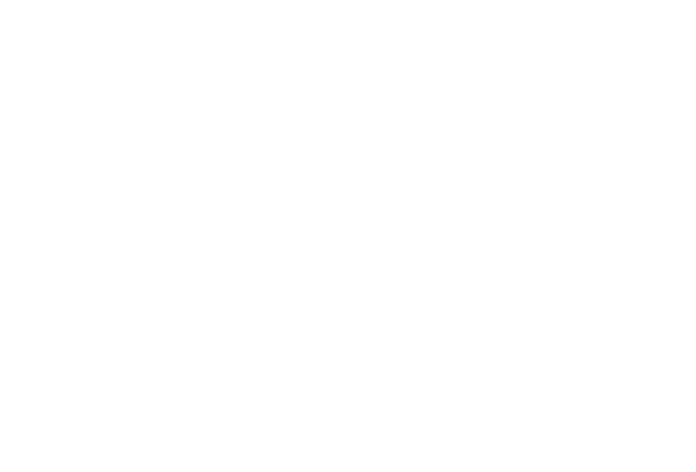

In [5]:
t=f.Get("EventTree")
c=ROOT.TCanvas()
t.Draw("gbt_0_calo")
c.Draw()

In [7]:
[b.GetName() for b in t.GetListOfBranches()]

['run',
 'Pol',
 'Nmax',
 'x',
 'y',
 's',
 'W',
 'Q2',
 'nu',
 'truex',
 'truey',
 'trueQ2',
 'trueW',
 'truenu',
 'hel',
 'truex',
 'truey',
 'trueW',
 'truenu',
 'pindex',
 'status',
 'px',
 'py',
 'pz',
 'p',
 'E',
 'pid',
 'vx',
 'vy',
 'vz',
 'chi2',
 'beta',
 'm',
 'theta',
 'eta',
 'phi',
 'truepx',
 'truepy',
 'truepz',
 'truep',
 'truept',
 'truem',
 'truetheta',
 'trueeta',
 'truephi',
 'truevx',
 'truevy',
 'truevz',
 'trueE',
 'is_CFR',
 'truepid',
 'trueparentid',
 'trueparentpid',
 'trueparentparentid',
 'trueparentparentpid',
 'pcal_sector',
 'pcal_e',
 'pcal_x',
 'pcal_y',
 'pcal_z',
 'pcal_lu',
 'pcal_lv',
 'pcal_lw',
 'pcal_m2u',
 'pcal_m2v',
 'pcal_m2w',
 'ecin_sector',
 'ecin_e',
 'ecin_x',
 'ecin_y',
 'ecin_z',
 'ecin_lu',
 'ecin_lv',
 'ecin_lw',
 'ecin_m2u',
 'ecin_m2v',
 'ecin_m2w',
 'ecout_sector',
 'ecout_e',
 'ecout_x',
 'ecout_y',
 'ecout_z',
 'ecout_lu',
 'ecout_lv',
 'ecout_lw',
 'ecout_m2u',
 'ecout_m2v',
 'ecout_m2w',
 'sector',
 'traj_x1',
 'traj_y1',
 